In [2]:
!pip install keras-tcn

In [3]:
from tcn import TCN
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
import warnings
from google.colab import files
warnings.filterwarnings("ignore")
import keras 

In [4]:
a = np.array([1,2,3])


In [10]:
a = np.insert(a,len(a),23)

In [11]:
a

array([ 1,  2,  1,  3,  4, 23])

In [ ]:
RUTA = '/content/drive/MyDrive/Universidad/Evapotranspiration-Prediction-2022/prediction/tcn/CNN - ET0/'
RUTA2 = '/content/drive/MyDrive/Universidad/Evapotranspiration-Prediction-2022/data_processing/data/'

import importlib.util

def module_from_file(module_name, file_path):
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module
# Equivalencia a from CNN import Ensemble_estruturado as es
es = module_from_file("es",RUTA+"CNN/Ensemble_estruturado.py")

# Equivalencia a from CNN import Ensemble_estruturado as es
basic = module_from_file("basic",RUTA+"CNN/basic.py")
eCNN = module_from_file("eCNN",RUTA+"CNN/Ensemble_CNN.py")
tcnn = module_from_file("tcnn",RUTA+"CNN/tcn-prediction.py")

In [ ]:
def get_search_dataset():
    # df1 = pd.read_csv('https://raw.githubusercontent.com/PatriciaLucas/Evapotranspiracao/master/ETo_setelagoas.csv', sep=',')
    # df1 = pd.read_csv(RUTA2+'Eto-Pudahuel.csv', sep=',')
    df1 = pd.read_csv(RUTA2+'Eto-Rinconada.csv', sep=',')
    df1 = df1.set_index(df1['Data'])
    df1.index = pd.to_datetime(df1.index,format="%d-%m-%Y")
    # df1 = df1[:'2022-06-01']
    series = df1.iloc[:,1]
    # train = series[:6939]
    # test = series[8035:] #ano de teste: 2015
    train = series[:-365]
    test = series[-365:]
    return train, test

train, test = get_search_dataset()
# df2 = pd.read_csv(RUTA2+'ETO_TEST.csv', sep=',')
# series2 = df2.iloc[:,1]
# test = series2[-365:]

# Carga de mejor configuración según métricas
def load_config(model,num_test):
  if num_test!=150:
    model.models[0] = {'pilhas': 2,'filters':2,'dropout':0.00438761,'norm':0,'lags':83,'num_conv':4,'kernel_size':5,'tipo':2}
    model.models[1] = {'pilhas': 2,'filters':2,'dropout':0.48961674,'norm':0,'lags':11,'num_conv':1,'kernel_size':11,'tipo':2}
    model.models[2] = {'pilhas': 1,'filters':1,'dropout':0.27417436,'norm':1,'lags':27,'num_conv':3,'kernel_size':5,'tipo':2}
    model.models[3] = {'pilhas': 1,'filters':0,'dropout':0.26143849,'norm':0,'lags':83,'num_conv':5,'kernel_size':5,'tipo':2}
    model.models[4] = {'pilhas': 2,'filters':2,'dropout':0.17972795,'norm':1,'lags':13,'num_conv':2,'kernel_size':2,'tipo':2}
    model.models[5] = {'pilhas': 1,'filters':1,'dropout':0.13627555,'norm':0,'lags':5,'num_conv':2,'kernel_size':3,'tipo':2}
  else:
    model.models[0] = {'pilhas': 1,'filters':2,'dropout':0.1354329256,'norm':1,'lags':33,'num_conv':2,'kernel_size':11,'tipo':2}
    model.models[1] = {'pilhas': 1,'filters':2,'dropout':0.2467018667,'norm':0,'lags':24,'num_conv':4,'kernel_size':3,'tipo':2}
    model.models[2] = {'pilhas': 1,'filters':2,'dropout':0.3882341108,'norm':1,'lags':36,'num_conv':3,'kernel_size':11,'tipo':2}
    model.models[3] = {'pilhas': 1,'filters':0,'dropout':0.08509099043,'norm':1,'lags':7,'num_conv':2,'kernel_size':5,'tipo':2}
    model.models[4] = {'pilhas': 2,'filters':2,'dropout':0.2470880412,'norm':0,'lags':25,'num_conv':4,'kernel_size':2,'tipo':2}
    model.models[5] = {'pilhas': 1,'filters':0,'dropout':0.1709679577,'norm':1,'lags':12,'num_conv':3,'kernel_size':3,'tipo':2}
  return model.models

In [ ]:
TYPE_MODEL = 'CNN3'
num = 6
savename = RUTA+'E'+TYPE_MODEL+'_MODELS/model_'

In [ ]:
model = eCNN.Ensemble_CNN(type_models = TYPE_MODEL, number = num) # Creating the ensemble with 6 CNNx models
model.generate_models()                                           # Generates CNN models
model.models = load_config(model,1)

In [ ]:
model.get_maxlag()

83

In [ ]:
model.fit(data = train[:].values) # Training of CNN models

In [ ]:
tcnn.saveModels(savename,model.trained_models) # Guardar modelos entrenados
mdls = tcnn.loadModels(savename,6)             # Cargar modelos entrenados

In [ ]:
# mdls = tcnn.loadModels(savename+'28-',6)

In [ ]:
forecastHorizon = 7
predictions = []
for i in range(forecastHorizon):
  kde_list = tcnn.probabilisticForecast(test,mdls)
  predicted_value = kde_list[0][0].sample(1000).mean()
  predictions.append(predicted_value)
  test_ = test.values
  test_ = np.insert(test_,len(test_),predicted_value)
  test_ = np.delete(test_,0)
  df_ = pd.DataFrame({'Eto':test_})
  test = df_['Eto']

In [ ]:
pred = tcnn.probabilisticForecast(test = test[:],models=mdls)

In [ ]:
predicted_values = tcnn.probabilisticForecast(test=test,models=mdls)
predicted_value = predicted_values[0][0].sample(1000).mean()

In [ ]:
# Point Forecast
yhat, y_test,_ = model.point_forecast(data = test.values, forecast_horizon=7)
rmse, mae, mape, r2 = model.metrics(yhat = yhat, y_test=y_test, forecast_horizon=7)
print("RMSE", rmse)
print("MAE",mae)
print("MAPE",mape)
print("R2",r2)
model_metrics = pd.DataFrame({'RMSE':rmse,'MAE':mae,'MAPE':mape,'R2':r2})

RMSE [0.5789486814851958, 0.6356547544651916, 0.6960281671363405, 0.7455262298936431, 0.8028915101460582, 0.8793796340335457, 0.9410225037574761]
MAE [0.44242942704376603, 0.4851137456332221, 0.5334890679341364, 0.5667504225547114, 0.6092663619072831, 0.6626210830976249, 0.7064342521358254]
MAPE [22.45262205549684, 23.180806004793123, 24.204873019440146, 24.376247696342194, 24.71396356574124, 25.47870154364229, 26.309001161244836]
R2 [0.9035334351436746, 0.8837108289489027, 0.8605719011509159, 0.8400358984675016, 0.8144715968258699, 0.7774387857569243, 0.7451429252307804]


In [ ]:
# Probabilistic Forecast
kde_list, y_test = model.probabilistic_forecast(data = test.values, forecast_horizon=7)

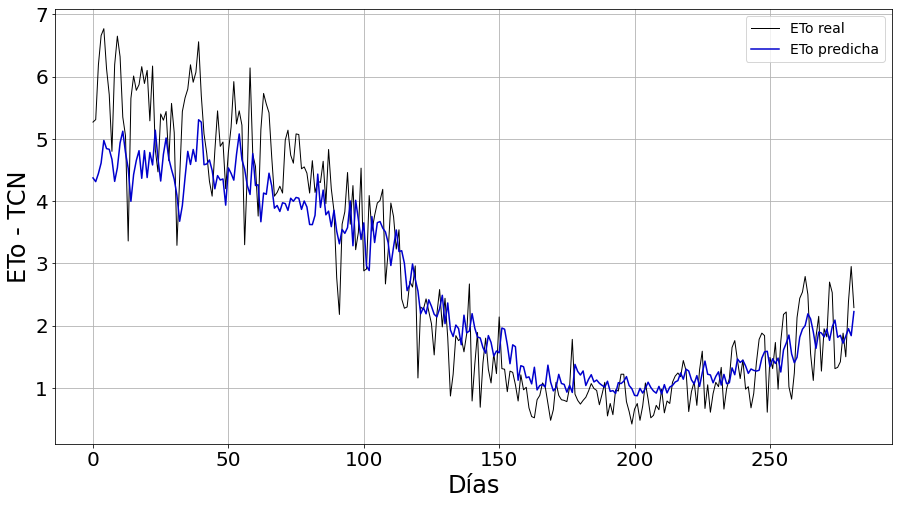

In [ ]:
# Time series Plot
DIAS_ATRAS = -0 # Para el gráfico
y_hat_CNN = np.zeros((len(y_test),100))
y_mean = np.zeros((len(y_test)))
y_max = np.zeros((len(y_test)))
y_min = np.zeros((len(y_test)))
x = np.zeros((len(y_test)))
for i in range(len(y_test)):
    y = kde_list[6][i].sample(100)
    y_mean[i] = y.mean()
    y_max[i] = y.max()
    y_min[i] = y.min()
    y_hat_CNN[i,:] = y.reshape(1,-1)
    x[i] = i

fig, ax = plt.subplots(figsize=[15,8])
plt.grid()
plt.plot(x[DIAS_ATRAS:],y_test[DIAS_ATRAS:],'-', color = 'black', ms=4, lw=1, alpha=1, label='ETo real')
plt.plot(x[DIAS_ATRAS:],y_mean[DIAS_ATRAS:],'-', color = 'mediumblue', ms=4, lw=1, alpha=1, label='ETo predicha',linewidth=1.5)
# ax.fill_between(x[DIAS_ATRAS:], y_min[DIAS_ATRAS:], y_max[DIAS_ATRAS:], color='mediumblue', alpha=0.15, label='Intervalo de confianza')
plt.tick_params(labelsize=20)
plt.legend(fontsize=14)
plt.xlabel("Días", fontsize=24)
plt.ylabel("ETo - TCN", fontsize=24);

In [ ]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
print(r2_score(y_test[-105:],y_mean[-105:]))
print(np.sqrt(mean_squared_error(y_test[-105:],y_mean[-105:])))
print(mean_absolute_error(y_test[-105:],y_mean[-105:]))

0.4681689299683468
0.42611292084352914
0.35088487500659554


In [ ]:
np.sqrt(mean_squared_error(y_test[-105:],y_mean[-105:]))/np.mean(y_test[-105:])

0.3353376987369517

In [ ]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
print(r2_score(y_test[-105:],y_mean[-105:]))
print(np.sqrt(mean_squared_error(y_test[-105:],y_mean[-105:])))
print(mean_absolute_error(y_test[-105:],y_mean[-105:]))

-1.4621497445766312
2.261004420864058
1.9690898844024896


In [ ]:
np.sqrt(mean_squared_error(y_test[-105:],y_mean[-105:]))/np.mean(y_test[-105:])

0.3247485435612501

In [ ]:
len(y_test)

282

In [ ]:
print(r2_score(y_test,y_mean))
print(np.sqrt(mean_squared_error(y_test,y_mean)))
print(mean_absolute_error(y_test,y_mean))

0.8588977545872013
0.7001943866753375
0.5399683703455627


In [ ]:
mean_squared_error(y_mean,y_test,squared=False)/((np.max(y_test)+np.min(y_test))/2)

0.19476895317811893